# <font style="color:blue">Project 3: Object Detection</font>





#### Maximum Points: 100



|Sr. no.|Section|Points|
|:-------|:-------|:------:|
|1|Plot Ground Truth Bounding Boxes|20|
|2|Training|25|
|3|Inference|15|
|4|COCO Detection Evaluation|25|
|5|COCO Detection Evaluation|15|

# <font style="color:purple">Download the config file and trainer package</font> 

In [1]:
!wget "https://raw.githubusercontent.com/RadimKozl/OpenCV_PyTorch_Project3/refs/heads/main/trainer.zip" -O ./trainer.zip
!ls /kaggle/working/
!unzip /kaggle/working/trainer.zip
!rm /kaggle/working/trainer.zip

--2024-12-17 13:48:27--  https://raw.githubusercontent.com/RadimKozl/OpenCV_PyTorch_Project3/refs/heads/main/trainer.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33856 (33K) [application/zip]
Saving to: './trainer.zip'

./trainer.zip       100%[===================>]  33.06K  --.-KB/s    in 0.004s  

2024-12-17 13:48:27 (8.14 MB/s) - './trainer.zip' saved [33856/33856]

trainer.zip
Archive:  /kaggle/working/trainer.zip
   creating: trainer/.ipynb_checkpoints/
  inflating: trainer/.ipynb_checkpoints/configuration-checkpoint.py  
  inflating: trainer/.ipynb_checkpoints/datasets-checkpoint.py  
  inflating: trainer/.ipynb_checkpoints/hooks-checkpoint.py  
  inflating: trainer/.ipynb_checkpoints/matplotlib_visualizer-checkpoint.py  
  inflating: trainer/.i

In [2]:
!wget "https://raw.githubusercontent.com/RadimKozl/OpenCV_PyTorch_Project3/refs/heads/main/config.yaml" -O ./config.yaml

--2024-12-17 13:48:31--  https://raw.githubusercontent.com/RadimKozl/OpenCV_PyTorch_Project3/refs/heads/main/config.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 511 [text/plain]
Saving to: './config.yaml'

./config.yaml       100%[===================>]     511  --.-KB/s    in 0s      

2024-12-17 13:48:31 (27.7 MB/s) - './config.yaml' saved [511/511]



# <font style="color:purple">Install external libraries</font> 

In [3]:
!pip install psutil 
!pip install h5py 

In [4]:
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

# <font style="color:purple">Imports libraries</font> 

In [5]:
import os
import gc
import json
import h5py
import csv
import yaml
import shutil
import pandas as pd
import numpy as np
import random
import time
import psutil
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import IPython
from PIL import Image
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

from operator import itemgetter
import multiprocessing as mp
mp.set_start_method('spawn', force=True)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset
from torchvision.transforms import functional as F

from torchvision import datasets, transforms
from torch.optim.lr_scheduler import MultiStepLR
from torch.nn.parallel import DataParallel
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

torch.multiprocessing.set_start_method('spawn', force=True)

import torchvision.models as models

from torchvision.ops import MultiScaleRoIAlign
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import FasterRCNN

In [7]:
from trainer import RCNNTrainer, hooks, configuration
from trainer.utils import patch_configs
from trainer.utils import setup_system

from trainer.metrics import APEstimator
from trainer.matplotlib_visualizer import MatplotlibVisualizer

from trainer.datasets import HDF5Dataset
from trainer.utils import collate_fn
from trainer.configuration import load_config_from_yaml

## <font style="color:orange">Function for check memory management</font> 

In [8]:
def memory_management():
    
    cpu_percent = psutil.cpu_percent(interval=1)
    print(f"CPU Usage: {cpu_percent}%")
    
    memory_usage = psutil.virtual_memory()
    print(f"Memory Usage: {memory_usage.percent}%")
    
    disk_usage = psutil.disk_usage('/')
    print(f"Disk Usage: {disk_usage.percent}%")

# <font style="color:purple">Download the Dataset</font> 



**[Download the Vehicle registration plate](https://www.dropbox.com/s/k81ljpmzy3fgtx9/Dataset.zip?dl=1)**





Download the Vehicle Registration Plate dataset from [here](https://www.dropbox.com/s/k81ljpmzy3fgtx9/Dataset.zip?dl=1) and unzip it. 



We will have the following directory structure:



```

Dataset

├── train

│   └── Vehicle registration plate

│       └── Label

└── validation

    └── Vehicle registration plate

        └── Label

```



Unzipping the file will give you a directory `Dataset`. This directory has two folder `train` and `validation`. Each train and validation folder has `Vehicle registration plate`  folder with `.jpg` images and a folder `Labels`.  `Labels` folder has bounding box data for the images.





For example,

For image: `Dataset/train/Vehicle registration plate/bf4689922cdfd532.jpg`

Label file is  `Dataset/train/Vehicle registration plate/Label/bf4689922cdfd532.txt`



There are one or more lines in each `.txt` file. Each line represents one bounding box.

For example,

```

Vehicle registration plate 385.28 445.15 618.24 514.225

Vehicle registration plate 839.68 266.066462 874.24 289.091462

```



We have a single class detection (`Vehicle registration plate detection`) problem. So bounding box details start from the fourth column in each row.



Representation is in `xmin`, `ymin`, `xmax`, and `ymax` format.



**It has `5308` training and `386` validation dataset.**



Data is downloaded from [Open Images Dataset](https://storage.googleapis.com/openimages/web/index.html)

#  <font style="color:green">1. Plot Ground Truth Bounding Boxes [20 Points]</font> 



**You have to show three images from validation data with the bounding boxes.**



The plotted images should be similar to the following:



<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-g1.png'>







<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-g2.png'>







<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-g3.png'>




##  <font style="color:blue">1.1. Class for create HDF5 file of datasets</font>

We create Json structure of `train`, `valid` and `test` datasets, for creating PyTorch Dataloader a standard module of trainer. We add test samples as [OpenCV_evalution_ALPR_dataset](https://www.kaggle.com/datasets/radimkzl/opencv-evalution-alpr-dataset).

In [9]:
class TransformDataset:
    def __init__(self, name_hdf5_file='datasets.hdf5', hdf5_image=False):
        self.name_hdf5_file = name_hdf5_file
        self.path_test_images = os.path.join('/kaggle', 'input', 'opencv-evalution-alpr-dataset', 'cars_ALPR_test', 'images')
        self.path_test_annotations = os.path.join('/kaggle', 'input', 'opencv-evalution-alpr-dataset', 'cars_ALPR_test','Annotations')
        self.path_train_images = os.path.join('/kaggle', 'input', 'vehicle-registration-plate', 'Dataset', 'train', 'Vehicle registration plate')
        self.path_valid_images = os.path.join('/kaggle', 'input', 'vehicle-registration-plate', 'Dataset', 'validation', 'Vehicle registration plate')
        self.hdf5_file = None
        self.hdf5_image = hdf5_image
        

    def __select_files(self, root_path, extensions=('.jpg', '.png')):
        """
        Select image files from the given directory with specified extensions.

        Args:
            root_path (str): Path to the directory containing images.
            extensions (tuple): Valid file extensions.

        Returns:
            list: List of file paths matching the extensions.
        """
        if not os.path.exists(root_path):
            print(f"Warning: Path {root_path} does not exist!")
            return []

        return [os.path.join(root_path, filename) for filename in os.listdir(root_path) if filename.endswith(extensions)]

    def __get_image_shape(self, image_path):
        """
        Get the shape (width, height, channels) of an image.

        Args:
            image_path (str): Path to the image file.

        Returns:
            list: [width, height, channels]
        """
        channel = None
        img = Image.open(image_path)
        w, h = img.size
        c = img.mode
        if c == 'RGB':
            channel = 3
        return [w, h, channel]

    def __select_data(self, file_path):
        """
        Parse annotation data from a file.

        Args:
            file_path (str): Path to the annotation file.

        Returns:
            tuple: Tuple of data (label_id, box_coordinates)
        """
        box_coordinates = []
        labels_id = []
        list_class_name = ['__background__', 'Vehicle registration plate']

        if not os.path.isfile(file_path):
            print(f"Warning: Annotation file {file_path} not found!")
            return []

        with open(file_path, 'r') as input_file:
            lines = input_file.readlines()

        for line in lines:
            parts = line.strip().split()
            if len(parts) < 5:
                print(f"Warning: Invalid annotation format in file {file_path}: {line.strip()}")
                continue

            label = parts[0] + ' ' + parts[1] + ' ' + parts[2]
            numbers = [round(float(num)) for num in parts[3:]]

            labels_id.append(list_class_name.index(label))
            box_coordinates.append(numbers)

        return (labels_id, box_coordinates)

    def process_files(self, file_paths, dataset_type):
        """
        Process image and annotation files and add them to the HDF5 dataset.

        Args:
            file_paths (list): List of image file paths.
            dataset_type (str): Dataset type ('train', 'valid', 'test').
        """
        for path in tqdm(file_paths, desc=f"Processing {dataset_type} files"):
            try:
                # Get image dimensions
                img_dim = self.__get_image_shape(path)
                name_dir, name_input = os.path.split(path)
                id_name, file_ext = os.path.splitext(name_input)

                # Determine label file path
                if dataset_type == 'test':
                    # Test dataset annotations are in a separate directory
                    path_label = os.path.join(self.path_test_annotations, f"{id_name}.txt")
                else:
                    annotations_dir = os.path.join(name_dir, 'Label')
                    path_label = os.path.join(annotations_dir, f"{id_name}.txt")

                # Read and process annotation data
                sub_data = self.__select_data(path_label)
                if not sub_data:
                    print(f"Warning: No annotations found for {path_label}. Skipping.")
                    continue

                # Prepare data dictionary
                data = {
                    "name_id": str(id_name),
                    "name": str(name_input),
                    "path": str(path),
                    "type": file_ext.lstrip('.'),
                    "dimension": img_dim,
                    "labels": sub_data[0],
                    "boxes": sub_data[1]
                }

                try:
                    # Serialize data and write to HDF5
                    # set dataset group
                    dataset_group = self.hdf5_file[dataset_type]
                    # Create a subgroup for the image
                    image_group = dataset_group.create_group(data['name_id'])
                    if self.hdf5_image:
                        # Add image path, labels, and boxes to the image group
                        img = Image.open(path)
                        img_array = np.array(img)
                        image_group.create_dataset('image', data=img_array)
                    
                        image_group.attrs['name'] = np.array(data['name'], dtype='S100')
                        image_group.attrs['type'] = np.array(data['type'], dtype='S3')
                        image_group.attrs['dimension'] = np.array(data['dimension'], dtype='float64')
                        image_group.attrs['labels'] = data['labels']
                        image_group.attrs['boxes'] = data['boxes']
                        image_group.attrs['link'] = np.array(path, dtype='S200')
                    else:
                        image_group.create_dataset('image_link', data=[path])
                        image_group.attrs['name'] = np.array(data['name'], dtype='S100')
                        image_group.attrs['type'] = np.array(data['type'], dtype='S3')
                        image_group.attrs['dimension'] = np.array(data['dimension'], dtype='float64')
                        image_group.attrs['labels'] = data['labels']
                        image_group.attrs['boxes'] = data['boxes']
                        
                except Exception as e:
                    print(f"Error processing: {e}")
            

            except Exception as e:
                print(f"Error processing file {path}: {e}")

    def create_hdf5_data(self):
        """
        Create HDF5 dataset file with train, valid, and test groups.
        """
        # Select files for each dataset type
        list_train_files = self.__select_files(self.path_train_images, ('.jpg', '.png'))
        list_valid_files = self.__select_files(self.path_valid_images, ('.jpg', '.png'))
        list_test_files = self.__select_files(self.path_test_images, ('.jpg', '.png'))

        # Validate file lists
        if not list_train_files:
            print("No training files found!")
        if not list_valid_files:
            print("No validation files found!")
        if not list_test_files:
            print("No test files found!")

        with h5py.File(os.path.join('/kaggle', 'working', self.name_hdf5_file), 'w') as self.hdf5_file:
            # Create dataset groups
            self.hdf5_file.create_group('train')
            self.hdf5_file.create_group('valid')
            self.hdf5_file.create_group('test')

            # Add metadata attributes
            self.hdf5_file.attrs['class_number'] = 2
            self.hdf5_file.attrs['names_class'] = ['__background__', 'Vehicle registration plate']

            # Process and add files
            self.process_files(list_train_files, 'train')
            self.process_files(list_valid_files, 'valid')
            self.process_files(list_test_files, 'test')

    def close(self):
        if hasattr(self, 'name_hdf5_file') and self.name_hdf5_file:
            self.hdf5_file.close()
        else:
            try:
                f = h5py.File(os.path.join('/kaggle', 'working', self.name_hdf5_file), 'w')
                f.close()
                print("File is closed...")
            except:
                  print("File is still locked, we close file...")  
            finally:
                self.hdf5_file.close()

        print("HDF5 dataset created successfully!")

##  <font style="color:blue">1.2. Create HDF5 file of datasets</font>

In [10]:
%%time
transform_dataset = TransformDataset(name_hdf5_file='datasets.hdf5', hdf5_image=False)
transform_dataset.create_hdf5_data()

Processing test files: 100%|██████████| 30/30 [00:00<00:00, 60.40it/s]

CPU times: user 5.65 s, sys: 2.7 s, total: 8.35 s
Wall time: 1min 7s


In [11]:
transform_dataset.close()
del transform_dataset

HDF5 dataset created successfully!


In [12]:
gc.collect()
memory_management()

CPU Usage: 3.0%
Memory Usage: 5.6%
Disk Usage: 74.6%


##  <font style="color:blue">1.3. Create Dataloaders for read data</font>

###  <font style="color:orange">Plot function of samples of data</font>

In [13]:
def plot_images(loader, rows=2, columns=3):
    """
    Plot few images with their bounding boxes.

    Args:
        loader (DataLoader): DataLoader containing the dataset.
        rows (int): Number of rows in the plot.
        columns (int): Number of columns in the plot.
    """
    plt.rcParams["figure.figsize"] = (15, 9)
    plt.figure()

    for images, targets in loader:
        for i in range(min(len(targets), rows * columns)):
            plt.subplot(rows, columns, i + 1)
            img = F.to_pil_image(images[i])
            plt.imshow(img)

            # Get bounding boxes and labels
            boxes = targets[i]['boxes'].numpy()
            labels = targets[i]['labels'].numpy()

            # Create an Axes instance
            ax = plt.gca()

            # Plot each bounding box
            for box, label in zip(boxes, labels):
                xmin, ymin, xmax, ymax = box
                width = xmax - xmin
                height = ymax - ymin
                rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                plt.text(xmin, ymin, f'Label: {label}', color='red', fontsize=12, backgroundcolor='none')

            plt.axis('off')

        plt.show()
        break


###  <font style="color:orange">1.3.1 Create train dataset</font>

In [14]:
path_hdf5_file = os.path.join('/kaggle','working','datasets.hdf5')

In [15]:
%%time
hdf5_train_dataset = HDF5Dataset(path_hdf5_file, 'train')

CPU times: user 3.36 ms, sys: 3.83 ms, total: 7.19 ms
Wall time: 7.02 ms


In [16]:
%%time
# Calculate mean and std of train dataset
mean_train, std_train = hdf5_train_dataset.calculate_mean_std_manual()
print(f"Calculated Mean: {mean_train}, Std: {std_train} of train dataset.")

Calculated Mean: [0.4346074  0.43316259 0.42894789], Std: [0.28065935 0.28091289 0.29091193] of train dataset.
CPU times: user 2min 58s, sys: 3.53 s, total: 3min 2s
Wall time: 3min 7s


In [17]:
# show samples
train_dataloader = torch.utils.data.DataLoader(
    hdf5_train_dataset, 
    batch_size=6, 
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=True
)

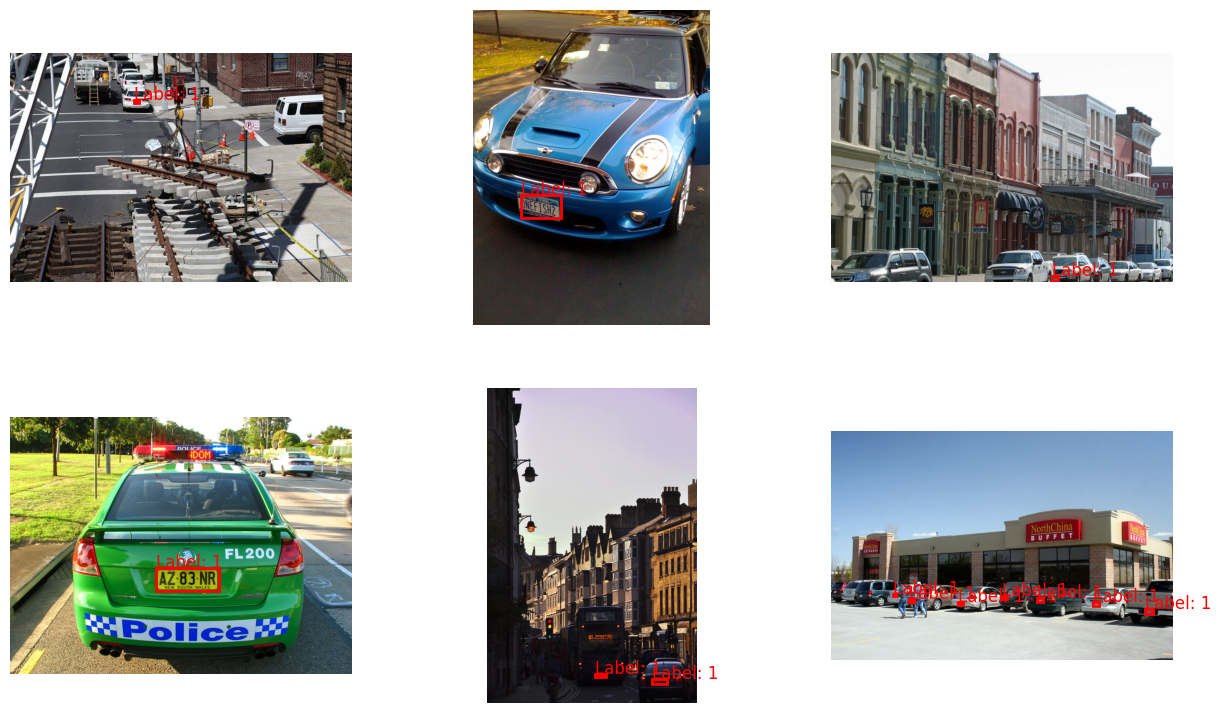

In [18]:
plot_images(train_dataloader, rows=2, columns=3)

In [19]:
del train_dataloader

###  <font style="color:orange">1.3.2 Create valid dataset</font>

In [20]:
%%time
hdf5_valid_dataset = HDF5Dataset(path_hdf5_file, 'valid')

CPU times: user 1.03 ms, sys: 957 µs, total: 1.99 ms
Wall time: 1.7 ms


In [21]:
%%time
# Calculate mean and std of train dataset
mean_valid, std_valid = hdf5_valid_dataset.calculate_mean_std_manual()
print(f"Calculated Mean: {mean_valid}, Std: {std_valid} of valid dataset.")
del mean_valid, std_valid

Calculated Mean: [0.40982729 0.40347295 0.39792533], Std: [0.2813981  0.27871906 0.28322028] of valid dataset.
CPU times: user 13.8 s, sys: 262 ms, total: 14 s
Wall time: 14.4 s


In [22]:
# show samples
valid_dataloader = torch.utils.data.DataLoader(
    hdf5_valid_dataset, 
    batch_size=6, 
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=True
)


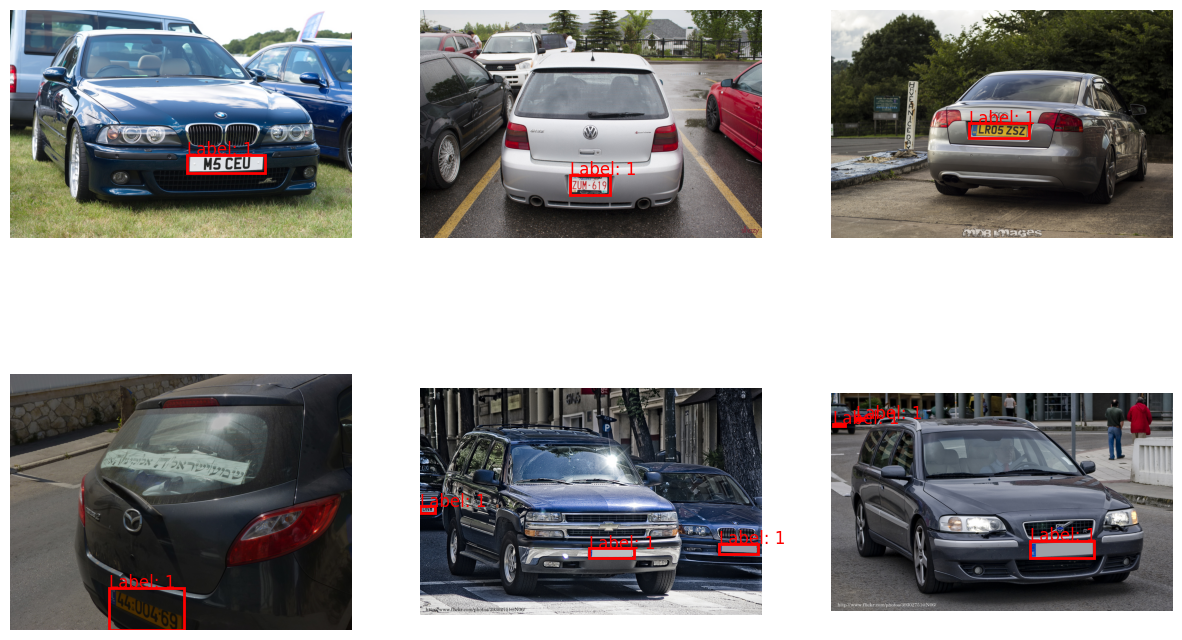

In [23]:
plot_images(valid_dataloader, rows=2, columns=3)

In [24]:
del valid_dataloader, hdf5_valid_dataset

###  <font style="color:orange">1.3.3 Create test dataset</font>

In [25]:
%%time
hdf5_test_dataset = HDF5Dataset(path_hdf5_file, 'test')

CPU times: user 1.17 ms, sys: 8 µs, total: 1.18 ms
Wall time: 970 µs


In [26]:
%%time
# Calculate mean and std of train dataset
mean_test, std_test = hdf5_test_dataset.calculate_mean_std_manual()
print(f"Calculated Mean: {mean_test}, Std: {std_test} of train dataset.")
del mean_test, std_test

Calculated Mean: [0.45828777 0.44046033 0.39260295], Std: [0.30443188 0.29303649 0.30604451] of train dataset.
CPU times: user 22.3 s, sys: 3.34 s, total: 25.6 s
Wall time: 26 s


In [27]:
# show samples
test_dataloader = torch.utils.data.DataLoader(
    hdf5_test_dataset, 
    batch_size=6, 
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=True
)

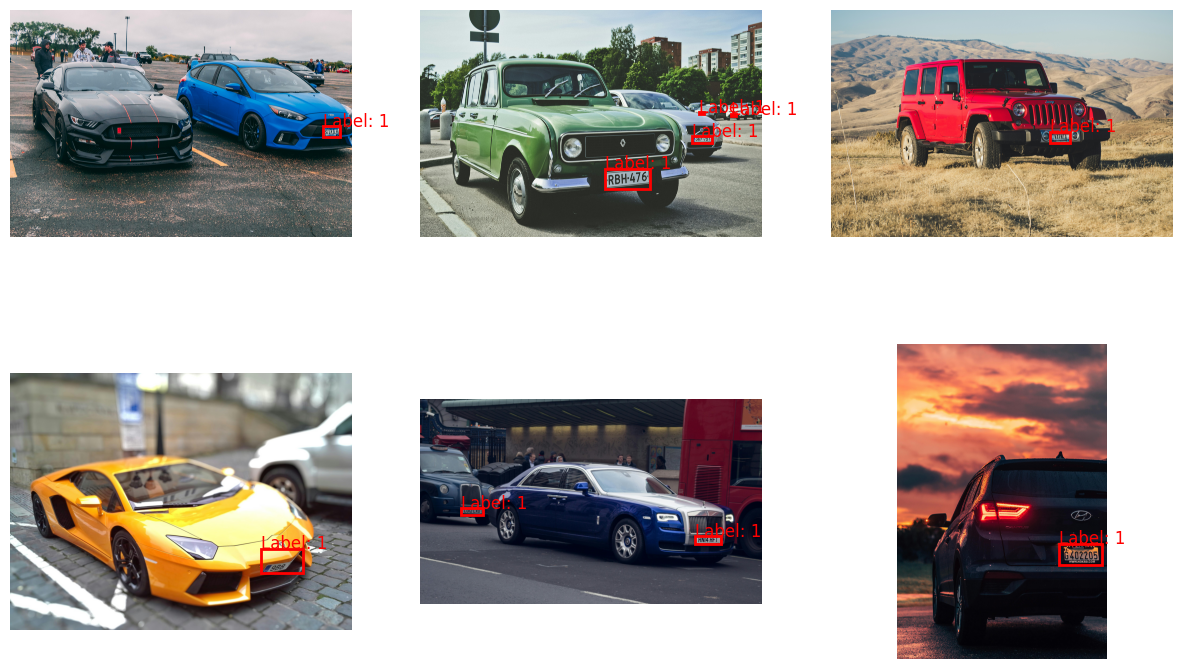

In [28]:
plot_images(test_dataloader, rows=2, columns=3)

In [29]:
del test_dataloader, hdf5_test_dataset

###  <font style="color:orange">1.3.4 Show class names</font>

In [30]:
list_class_names = hdf5_train_dataset.names_class

# Access metadata
print(f"Class Number: {hdf5_train_dataset.class_number}")
print(f"Class Names: {list_class_names}")

Class Number: 2
Class Names: ['__background__', 'Vehicle registration plate']


In [31]:
gc.collect()
memory_management()

CPU Usage: 0.0%
Memory Usage: 12.6%
Disk Usage: 74.6%


#  <font style="color:green">2. Training [25 Points]</font> 



- **Write your training code in this section.**



- **You also have to share ([shared logs example](https://tensorboard.dev/experiment/JRtnsKbwTaq1ow6nPLPGeg)) the loss plot of your training using tensorboard.dev.** 



How to share TensorBoard logs using tensorboard.dev find [here](https://courses.opencv.org/courses/course-v1:OpenCV+OpenCV-106+2019_T1/courseware/b1c43ffe765246658e537109e188addb/d62572ec8bd344db9aeae81235ede618/4?activate_block_id=block-v1%3AOpenCV%2BOpenCV-106%2B2019_T1%2Btype%40vertical%2Bblock%40398b46ddcd5c465fa52cb4d572ba3229).

##  <font style="color:blue">2.1. Create Model</font>

###  <font style="color:orange">2.1.1 Simple model</font>

In [32]:
def faster_rcnn_pretrained_model(num_classes):
    # load an instance detection model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

###  <font style="color:orange">2.1.2 Model update / proposed model (Fine-tuning)</font>

In [33]:
def faster_rcnn_pretrained_model_alexnet(num_classes):
    
    # Get the backbone of any pretrained network, we'll use AlexNet
    alexnet = models.alexnet(pretrained=True)
    new_backbone = alexnet.features
    new_backbone.out_channels = 256
    
    # Configure the anchors. We shall have 12 different anchors.
    new_anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256),),
                                          aspect_ratios=((0.5, 1.0, 2.0),))
    
    # Configure the output size of ROI-Pooling layer.
    # We shall end up with (num_boxes, num_features, 4, 4) after the ROIPooling layer
    new_roi_pooler = MultiScaleRoIAlign(featmap_names=['0'], output_size=4, sampling_ratio=1)
    
    
    # let's use dummy variables for mean, std, min_size and max_size
    min_size = 300
    max_size = 1050
    mean = mean_train
    std = std_train
   
    # Instantiate the Faster-rcnn model with the variables declared above.
    frcnn_model = FasterRCNN(backbone=new_backbone,
                          num_classes=num_classes,
                          min_size=min_size,
                          max_size=max_size,
                          image_mean=mean,
                          image_std=std,
                          rpn_anchor_generator=new_anchor_generator,
                          box_roi_pool=new_roi_pooler)

    return frcnn_model

##  <font style="color:blue">2.2. Config file</font>

###  <font style="color:orange">2.2.1 Update config file</font>

In [34]:
config_ex_path = os.path.join('/kaggle','working','config.yaml') # path of yaml file

In [35]:
# load yaml file
with open(config_ex_path, 'r') as f:
    config = yaml.safe_load(f)

In [36]:
# set system config values
config['system']['seed'] = 42
config['system']['cudnn_benchmark_enabled'] = False
config['system']['cudnn_deterministic'] = True

# set dataset config values
config['dataset']['root_dir'] = os.path.join('/','kaggle','working')
config['dataset']['hdf5_file'] = "datasets.hdf5"

# set dataloader config values
config['dataloader']['batch_size'] = 250
config['dataloader']['num_workers'] = 2
config['dataloader']['data_augmentation'] = False

# set optimizer config values
config['optimizer']['learning_rate'] = 0.001
config['optimizer']['momentum'] = 0.9
config['optimizer']['weight_decay'] = 0.0001
config['optimizer']['lr_step_milestones'] = [30, 40]
config['optimizer']['lr_gamma'] = 0.1

# set trainer config values
config['trainer']['model_dir'] = os.path.join('/','kaggle','working','models')
config['trainer']['model_save_best'] = True
config['trainer']['model_saving_frequency'] = 1
config['trainer']['device'] = "cuda"
config['trainer']['epoch_num'] = 50
config['trainer']['progress_bar'] = False
config['trainer']['normalization'] = False

In [37]:
with open(config_ex_path, 'w') as f:
    yaml.dump(config, f)

###  <font style="color:orange">2.2.2 Load Config data from file</font>

In [38]:
system_config, dataset_config, dataloader_config, optimizer_config, trainer_config = load_config_from_yaml(config_ex_path)

##  <font style="color:blue">2.2. Create Experiment Class</font>

In [39]:
class Experiment:
    def __init__(
        self,
        system_config: configuration.SystemConfig = system_config,
        dataset_config: configuration.DatasetConfig = dataset_config,  
        dataloader_config: configuration.DataloaderConfig = dataloader_config,
        optimizer_config: configuration.OptimizerConfig = optimizer_config,
    ):
        self.system_config = system_config
        setup_system(system_config)
        
        # fruit detection data has 1-classes. Anything other than these three classes is called background
        self.classes = list_class_names
        
        # written custom dataset class of our dataset
        self.dataset_train = HDF5Dataset(
            hdf5_file=path_hdf5_file, 
            dataset_type='train',
            transform=None,
            train=True,
            width_image=1024
        )
          
        self.loader_train = torch.utils.data.DataLoader(
            dataset=self.dataset_train,
            batch_size=dataloader_config.batch_size,
            shuffle=True,
            collate_fn=collate_fn,
            num_workers=dataloader_config.num_workers,
            pin_memory=True
        )
        

        self.dataset_valid = HDF5Dataset(
            hdf5_file=path_hdf5_file, 
            dataset_type='valid',
            transform=None,
            train=False,
        )
        
        
        self.loader_valid = torch.utils.data.DataLoader(
            dataset=self.dataset_valid,
            batch_size=dataloader_config.batch_size,
            shuffle=False,
            collate_fn=collate_fn,
            num_workers=dataloader_config.num_workers,
            pin_memory=True
        )

        self.dataset_test = HDF5Dataset(
            hdf5_file=path_hdf5_file, 
            dataset_type='test',
            transform=None,
            train=False,
        )
        
        
        self.loader_test = torch.utils.data.DataLoader(
            dataset=self.dataset_test,
            batch_size=dataloader_config.batch_size,
            shuffle=False,
            collate_fn=collate_fn,
            num_workers=dataloader_config.num_workers,
            pin_memory=True
        )
        
        # get faster rcnn model pretrained on coco
        #self.model = faster_rcnn_pretrained_model_alexnet(len(self.classes))
        self.model = faster_rcnn_pretrained_model(len(self.classes))
        
        self.metric_fn = APEstimator(classes=self.classes)
        
        params = [p for p in self.model.parameters() if p.requires_grad]
        self.optimizer = optim.SGD(
            params,
            lr=optimizer_config.learning_rate,
            weight_decay=optimizer_config.weight_decay,
            momentum=optimizer_config.momentum
        )
        self.lr_scheduler = MultiStepLR(
            self.optimizer, milestones=optimizer_config.lr_step_milestones, gamma=optimizer_config.lr_gamma
        )
        self.visualizer = MatplotlibVisualizer()

    def run(self, trainer_config: trainer_config) -> dict:  
        setup_system(self.system_config)
        device = torch.device(trainer_config.device)
        self.model = self.model.to(device)

        model_trainer = Trainer(
            model=self.model,
            loader_train=self.loader_train,
            loader_test=self.loader_valid,
            metric_fn=self.metric_fn,
            optimizer=self.optimizer,
            lr_scheduler=self.lr_scheduler,
            device=device,
            data_getter=itemgetter("image"),
            target_getter=itemgetter("target"),
            stage_progress=trainer_config.progress_bar,
            get_key_metric=itemgetter("mAP"),
            visualizer=self.visualizer,
            model_save_best=trainer_config.model_save_best,
            model_saving_frequency=trainer_config.model_saving_frequency,
            save_dir=trainer_config.model_dir
        )

        model_trainer.register_hook("train", hooks.train_hook_faster_rcnn)
        model_trainer.register_hook("test", hooks.test_hook_faster_rcnn)
        model_trainer.register_hook("end_epoch", hooks.end_epoch_hook_faster_rcnn)
        self.metrics = model_trainer.fit(trainer_config.epoch_num)
        return self.metrics

    def draw_bboxes(self, rows, columns, trainer_config:  trainer_config):
        # load the best model
        if trainer_config.model_save_best:
            self.model.load_state_dict(
                torch.
                load(os.path.join(trainer_config.model_dir, self.model.__class__.__name__) + '_best.pth')
            )
        # or use the last saved
        self.model = self.model.eval()

        fig, ax = plt.subplots(
            nrows=rows, ncols=columns, figsize=(15, 30), gridspec_kw={
                'wspace': 0,
                'hspace': 0.05
            }
        )
        
        colors = [(255, 0, 0), (0, 225, 0), (0, 0, 225)]

        for axi in ax.flat:
            index = random.randrange(len(self.loader_test.dataset))

            image, targets = self.loader_test.dataset[index]

            device = torch.device(trainer_config.device)
            image = image.to(device).clone()

            detections = self.model(image.unsqueeze(0))
            bboxes = detections[0]['boxes'].cpu().detach().numpy()
            labels = detections[0]['labels'].cpu().detach().numpy()
            scores = detections[0]['scores'].cpu().detach().numpy()

            with torch.no_grad():
                img = image.cpu()
                img = img.numpy().transpose(1, 2, 0)
                img = (img * 255.).astype(np.uint8)
                gt_img = img.copy()
                pred_img = img.copy()

                for i, box in enumerate(targets['boxes']):
                    label = targets['labels'][i]
                    cls = self.classes[label]
                    clr = colors[label-1]
                    gt_img = cv2.rectangle(
                        gt_img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), clr, thickness=2)
                    gt_img = cv2.putText(gt_img, cls, (int(box[0]), int(box[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 
                                         0.9, clr, 2)
                    
                for i, box in enumerate(bboxes):
                    label = labels[i]
                    score = scores[i]
                    cls = self.classes[label]
                    clr = colors[label-1]
                    cls_score = '{0}:{1:.2}'.format(cls, score)
                    pred_img = cv2.rectangle(
                        pred_img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), clr, thickness=2)
                    pred_img = cv2.putText(pred_img, cls_score, (int(box[0]), int(box[1])-10), 
                                           cv2.FONT_HERSHEY_SIMPLEX, 0.9, clr, 2)

                merged_img = np.concatenate((gt_img, pred_img), axis=1)
                axi.imshow(merged_img)
                axi.axis('off')
        fig.show()
    

##  <font style="color:blue">2.3. Run Experiment</font>

In [ ]:
if __name__ == '__main__':
    dataloader_config, trainer_config = patch_configs(epoch_num_to_set=100, batch_size_to_set=2)

    dataset_config = configuration.DatasetConfig(
        root_dir="data",
    )
    
    optimizer_config = configuration.OptimizerConfig(
        learning_rate=5e-3, 
        lr_step_milestones=[50], 
        lr_gamma=0.1, 
        momentum=0.9, 
        weight_decay=1e-5
    )
    
    experiment = Experiment(
        dataset_config=dataset_config, 
        dataloader_config=dataloader_config, 
        optimizer_config=optimizer_config
    )
    
    # Run the experiment / start training
    experiment.run(trainer_config)

#  <font style="color:green">3. Inference [15 Points]</font> 



**You have to make predictions from your trained model on three images from the validation dataset.**



The plotted images should be similar to the following:



<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-p1.png'>







<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-p2.png'>







<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-p3.png'>






In [ ]:
if __name__ == '__main__':
    experiment.draw_bboxes(4, 1, trainer_config)

#  <font style="color:green">4. COCO Detection Evaluation [25 Points]</font> 



**You have to evaluate your detection model on COCO detection evaluation metric.**



For your reference here is the coco evaluation metric chart:





---



<img src="https://www.learnopencv.com/wp-content/uploads/2020/03/c3-w9-coco_metric.png">



---



#### <font style="color:red">The expected `AP` (primary challenge metric) is more than `0.5`.</font>



**The expected output should look similar to the following:**



```

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.550

 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.886

 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.629

 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.256

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.653

 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.627

 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.504

 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.629

 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.633

 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.380

 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.722

 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.704

```




# <font style="color:green">5. Run Inference on a Video [15 Points]</font>



#### [Download the Input Video](https://www.dropbox.com/s/g88o4dx18zpgn8k/projet3-input-video.mp4?dl=1)



**You have to run inference on a video.** 



You can download the video from [here](https://www.dropbox.com/s/g88o4dx18zpgn8k/projet3-input-video.mp4?dl=1).



#### <font style="color:red">Upload the output video on youtube and share the link. Do not upload the video in the lab.</font>

In [ ]:
from IPython.display import YouTubeVideo, display

video = YouTubeVideo("18HWHCevFdU", width=640, height=360)

display(video)

**Your output video should have a bounding box around the vehicle registration plate.**

In [ ]:
video = YouTubeVideo("5SgCuee7AMs", width=640, height=360)

display(video)

**You can use the following sample code to read and write a video.**

In [ ]:
def video_read_write(video_path):

    """

    Read video frames one-by-one, flip it, and write in the other video.

    video_path (str): path/to/video

    """

    video = cv2.VideoCapture(video_path)

    

    # Check if camera opened successfully

    if not video.isOpened(): 

        print("Error opening video file")

        return

    

    # create video writer

    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))

    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

    frames_per_second = video.get(cv2.CAP_PROP_FPS)

    num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    

    output_fname = '{}_out.mp4'.format(os.path.splitext(video_path)[0])

    

    output_file = cv2.VideoWriter(

        filename=output_fname,

        # some installation of opencv may not support x264 (due to its license),

        # you can try other format (e.g. MPEG)

        fourcc=cv2.VideoWriter_fourcc(*"x264"),

        fps=float(frames_per_second),

        frameSize=(width, height),

        isColor=True,

    )

    

        

    i = 0

    while video.isOpened():

        ret, frame = video.read()

        if ret:

            

            output_file.write(frame[:, ::-1, :])

#             cv2.imwrite('anpd_out/frame_{}.png'.format(str(i).zfill(3)), frame[:, ::-1, :])

            i += 1

        else:

            break

        

    video.release()

    output_file.release()

    

    return